In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib import pyplot
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')


In [2]:
data=pd.read_csv(r"H:\Warehouse\Data\Beynon_MCP\mzml\Liver_HW_2h_L0_Quant.csv")
data.head()

,Proteins,sequence,charge,neh,seqmass,startelution,endelution,scannumber,m0,m1,m2,m3,m4,m5,intensity_m0,intensity_m1,intensity_m2,intensity_m3,intensity_m4,intensity_m5
0,CPSM_MOUSE,AADTIGYPVMIR,2,22,653.844823,46.02766,46.88983,26607,0.446006,0.327426,0.153400,0.053645,0.015095,0.003567,1.612955e+09,1.119211e+09,491033600.0,168636700.0,38751230.0,9720512.0
1,CPSM_MOUSE,AADTIGYPVMIR,3,22,436.232308,45.86283,46.36283,26607,0.446006,0.327426,0.153400,0.053645,0.015095,0.003567,1.995042e+07,1.051564e+07,4456587.0,1448822.0,608702.8,477183.7
2,CPSM_MOUSE,AAEYPSVTNYLYVTYNGQEHDIK,3,41,892.425636,51.29267,51.79267,30417,0.207041,0.310947,0.248840,0.139814,0.061592,0.022569,4.071375e+06,4.540918e+06,4234929.0,3150370.0,992024.6,0.0
3,CPSM_MOUSE,ADDNcVTVcNMENVDAMGVHTGDSVVVAPAQTLSNAEFQMLR,4,81,1142.267022,69.11633,69.61633,42669,0.080018,0.164762,0.213066,0.202723,0.154741,0.099688,1.076987e+06,6.782778e+05,1348157.0,1440299.0,364592.4,684766.6
4,CPSM_MOUSE,AERPDGLILGMGGQTAL,2,36,849.945799,55.17333,55.67333,33149,0.365573,0.336299,0.186716,0.076777,0.025435,0.007105,4.413084e+07,3.664826e+07,20495300.0,7429287.0,1787580.0,0.0


In [3]:
BW = [0, 0.0386, 0.0448, 0.0458, 0.046, 0.046, 0.046, 0.046, 0.046, 0.046, 0.046, 0.046]
allTime = [0, 1, 2, 3, 6, 7, 9, 13, 16, 21, 24, 31]
ph=1.5574E-4


def get_I0_t(time,data,index):
    index_t=allTime.index(time)
    suffix="" if index_t==0 else f".{index_t}"
    total=0
    for i in range(6):
        try:total+= int(data.loc[index,f"intensity_m{i}"])
        except: continue
    
    ria=None
    
    if total!=0: 
        try:
            ria=int(data.loc[index,f"intensity_m0"])/total
        except: ria=None
        
    return ria

In [4]:
import numpy as np

def compute_snr(ground_truth, experimental, in_db=False):
    """
    Compute the Signal-to-Noise Ratio (SNR) between two spectra.

    Parameters:
        ground_truth (array-like): Ground truth spectrum (signal), e.g., [m0, m1, ..., mN]
        experimental (array-like): Experimental spectrum, e.g., [a0, a1, ..., aN]
        in_db (bool): If True, returns SNR in decibels (dB)

    Returns:
        float: SNR value (linear or dB)
    """
    ground_truth=[i/sum(ground_truth) for i in ground_truth]
    experimental=[i/sum(experimental) for i in experimental]
    
    m = np.asarray(ground_truth)
    a = np.asarray(experimental)
    

    if m.shape != a.shape:
        raise ValueError("Input arrays must have the same shape.")

    signal_power = np.sum(m ** 2)
    noise_power = np.sum((a - m) ** 2)

    if noise_power == 0:
        return np.inf  # perfect match

    snr = signal_power / noise_power

    if in_db:
        return 10 * np.log10(snr)
    else:
        return snr


def plot_boxPlotAbudanceRD(_rd2,_testdata):
    # Sample data (list of values)
    data = [ math.log(h,10) for h in [min(_testdata['abudance'].values[i],_testdata['abudance'].values[i]) for i in range(_testdata.shape[0])]]
    bins = [0,4,5,6, 7,12]
    grouped_data = pd.cut(data, bins=bins,right=False) #labels=labels,
    # Show the original data with their corresponding groups
    df = pd.DataFrame({'Value': data, 'Group': grouped_data})
    df['rd']=_rd2#[abs(x) for x in _rd2]
    df=df.dropna()
    # print(df)
    
    # print(df.head())


    plt.rc('font',size=13)
    # Create a box plot
    # ax=sns.boxplot(x='Group', y='rd', data=df, palette='Spectral', fill=True)  
    ax=sns.violinplot(x='Group', y='rd', data=df, zorder=0, palette='Spectral', fill=True)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    
    #=========================================
    # Add the number of observations above each box
    categories = df['Group'].unique()
    print(categories)
    
    cat_index={"[7, 12)":4, "[5, 6)":2, "[4, 5)":1, "[6, 7)":3, "[0, 4)":0}

    # Add the number of observations above each box
    for i, category in enumerate(categories):
        # print(i,category,cat_index[str(category)])
        # Get the number of observations for the current category
        count = df[df['Group'] == category].shape[0]
        print(i,category,cat_index[str(category)],count)        
        
        temp_text= f'n={count}' if cat_index[str(category)]==0 else f'={count}'
        ax.text(cat_index[str(category)]+0.35, df.rd.max(), temp_text, ha='center')

    
    plt.ylabel(r'$\frac{|{I_0(t)}_{Multiplexed\:samples} - {I_0(t)}_{Single-sample }|}{ 0.5*({I_0(t)}_{Multiplexed\:samples} + {I_0(t)}_{Single-sample })}$')
    plt.xlabel(r'$Abundance$')
    

In [5]:
error,abudance,snr,ioncount=[],[],[],[]
for index in tqdm(range(data.shape[0])):
    M0=data.loc[index,'m0']
    I0_0_exp=get_I0_t(0,data,index)
    if I0_0_exp == None: continue
       
    snr_val=compute_snr([ data.loc[index,f'm{i}']  for i in range(6)],
                        [ data.loc[index,f'intensity_m{i}']  for i in range(6)],True)
    A0_exp=data.loc[index,'intensity_m0']/100 
    error.append( (I0_0_exp - M0)/M0  )       
    abudance.append(A0_exp) 
    snr.append(snr_val)
    ioncount.append(sum( [ 1  for i in range(6) if data.loc[index,f'intensity_m{i}'] !=0] ))

  0%|          | 0/22256 [00:00<?, ?it/s]

100%|██████████| 22256/22256 [00:05<00:00, 3717.78it/s]


In [6]:
summary_data=pd.DataFrame()
summary_data['log_abudance']=[math.log(x,10) for x in abudance]
summary_data['abudance']=abudance
summary_data['error']=error
summary_data['log_error']=[math.log(abs(x),10) for x in error]
summary_data['snr']=snr
summary_data['ioncount']=ioncount

summary_data.head()

# log_abudance=[math.log(x,10) for x in abudance]
# log_error=[math.log(abs(x),10) for x in error]

# # plt.scatter(log_abudance,snr)
# plt.scatter(snr,error)

,log_abudance,abudance,error,log_error,snr,ioncount
0,7.207622,16129550.00,0.051197,-1.290753,27.010099,6
1,5.299952,199504.20,0.194192,-0.711768,14.757757,6
2,4.609741,40713.75,0.157445,-0.802871,16.119335,5
3,4.032210,10769.87,1.406409,0.148112,8.355709,6
4,5.644742,441308.40,0.092547,-1.033638,23.293577,5


[[7, 12), [5, 6), [4, 5), [6, 7), [0, 4)]
Categories (5, interval[int64, left]): [[0, 4) < [4, 5) < [5, 6) < [6, 7) < [7, 12)]
0 [7, 12) 4 73
1 [5, 6) 2 7966
2 [4, 5) 1 11167
3 [6, 7) 3 1408
4 [0, 4) 0 1642


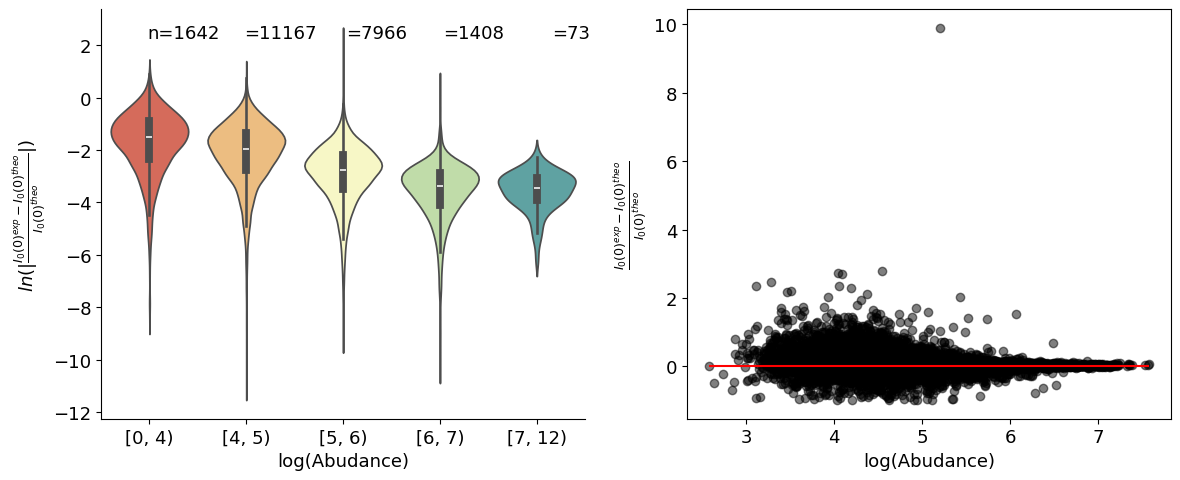

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_boxPlotAbudanceRD([math.log(abs(x)) for x in error],summary_data)  
plt.ylabel(r"$ln(|\frac{ I_0(0)^{exp} - I_0(0)^{theo} }{I_0(0)^{theo}}|)$")
plt.xlabel("log(Abudance)")

plt.subplot(1,2,2)
plt.scatter(summary_data['log_abudance'],summary_data['error'],c='k',alpha=0.5)
plt.hlines(y=0,xmin= min(summary_data['log_abudance']),xmax=max(summary_data['log_abudance']),colors='red')
# plt.xlabel("ln(Abudance)")
plt.ylabel(r"$\frac{ I_0(0)^{exp} - I_0(0)^{theo} }{I_0(0)^{theo}}$")
plt.xlabel("log(Abudance)")

plt.tight_layout()
plt.savefig("abudance_vs_I0_error.jpeg",dpi=900)

[[7, 12), [5, 6), [4, 5), [6, 7), [0, 4)]
Categories (5, interval[int64, left]): [[0, 4) < [4, 5) < [5, 6) < [6, 7) < [7, 12)]
0 [7, 12) 4 73
1 [5, 6) 2 7966
2 [4, 5) 1 11167
3 [6, 7) 3 1408
4 [0, 4) 0 1642


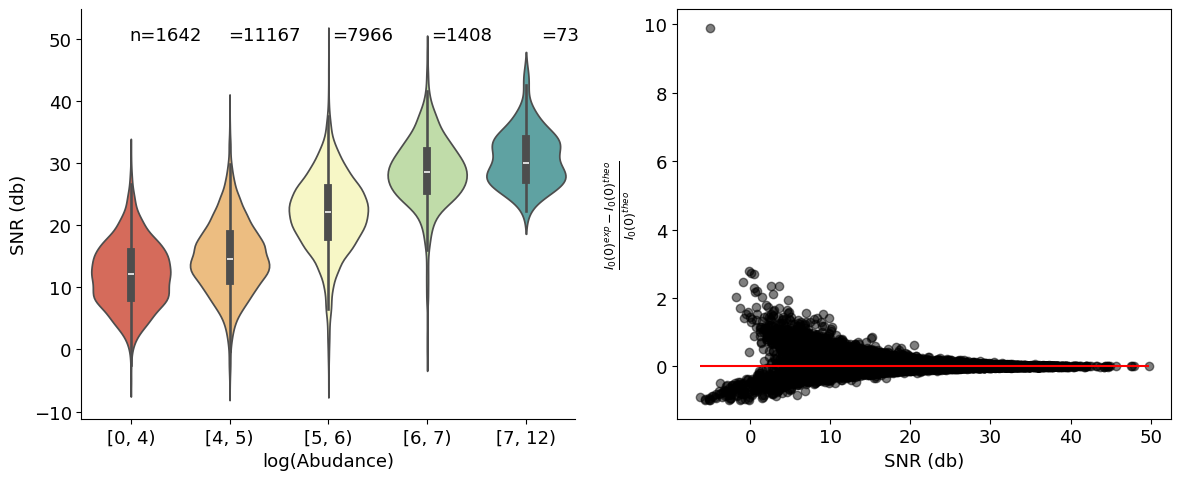

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_boxPlotAbudanceRD(snr,summary_data)  
plt.ylabel(r"SNR (db)")
plt.xlabel("log(Abudance)")

plt.subplot(1,2,2)
plt.scatter(snr,error,c='k',alpha=0.5)
# plot_hitmap(summary_data['log_abudance'],snr)
plt.hlines(y=0,xmin= min(summary_data['snr']),xmax=max(summary_data['snr']),colors='red')
plt.ylabel(r"$\frac{ I_0(0)^{exp} - I_0(0)^{theo} }{I_0(0)^{theo}}$")
plt.xlabel(r"SNR (db)")

plt.tight_layout()
plt.savefig("abudance_vs_snr.jpeg",dpi=900)

In [9]:

_testdata=summary_data.copy()
_rd2=ioncount
data = [ math.log(h,10) for h in [min(_testdata['abudance'].values[i],_testdata['abudance'].values[i]) for i in range(_testdata.shape[0])]]
bins = [0,4,5,6, 7,12]
grouped_data = pd.cut(data, bins=bins,right=False) #labels=labels,
# Show the original data with their corresponding groups
df = pd.DataFrame({'Value': data, 'Group': grouped_data})
df['rd']=[abs(x) for x in _rd2]
df['Group']=[str(x) for x in df['Group']]
df=df.dropna()


In [10]:
_group=sorted(df.Group.unique())

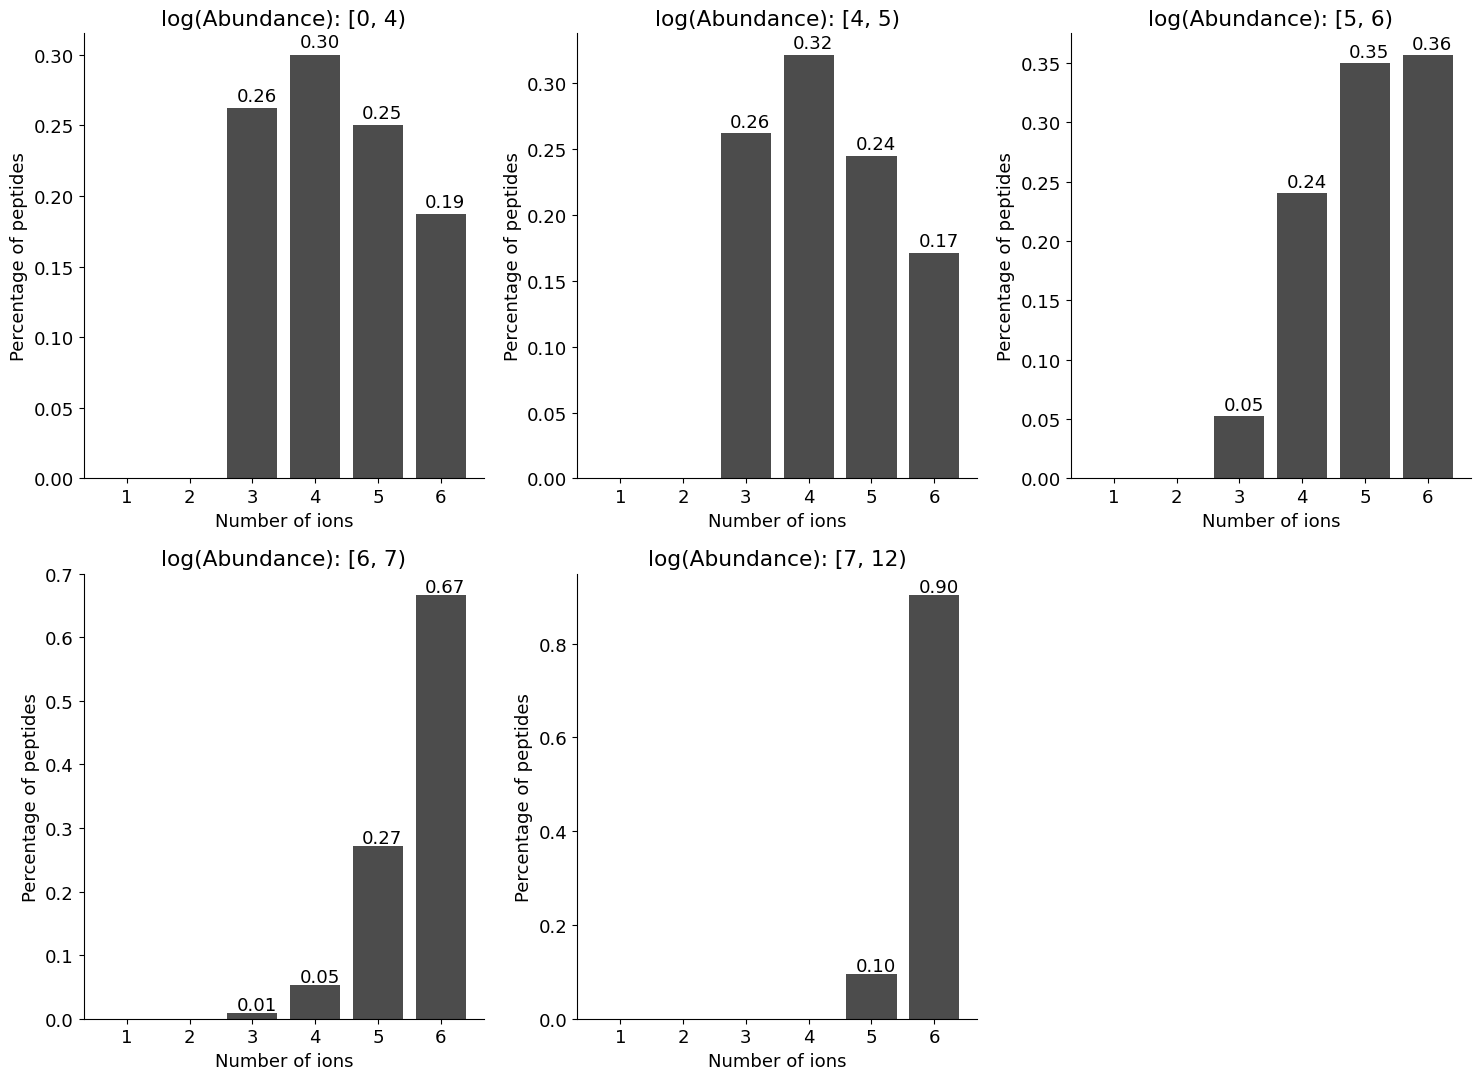

In [14]:
plt.figure(figsize=(15,11))
for index in range(len(_group)):
    plt.subplot(2,3,index+1)
    temp=df[df.Group==_group[index]]
    x=range(1,7)
    y=[temp[temp.rd==i].shape[0]/temp.shape[0] for i in x]
    plt.bar(x, y,color='k',alpha=0.7)
    for i in range(6):
        if y[i]>0:    plt.text(x[i]-0.25,y[i]+0.005,f"{y[i]:.2f}")
    plt.title(f"log(Abundance): {_group[index]}")

    ax=plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel("Number of ions")
    plt.ylabel("Percentage of peptides")
    

plt.tight_layout()
plt.savefig("abudance_vs_Ion.jpeg",dpi=900)